In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

2023-04-10 13:04:57.646757: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 13:04:59.485750: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-10 13:04:59.499452: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-10 13:05:07.051205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/cmathan/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of Tensor

In [2]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [3]:
def plot_detections(image_np, boxes, classes, scores, category_index, figsize=(12, 16), image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [4]:
def plot_detections_tensor(image_np, boxes, classes, scores, category_index, figsize=(12, 16),image_name=None):
  
  """Draws bounding boxes, masks, and keypoints on batch of image tensors.
  Args:
    images: A 4D uint8 image tensor of shape [N, H, W, C]. If C > 3, additional
      channels will be ignored. If C = 1, then we convert the images to RGB
      images.
    boxes: [N, max_detections, 4] float32 tensor of detection boxes.
    classes: [N, max_detections] int tensor of detection classes. Note that
      classes are 1-indexed.
    scores: [N, max_detections] float32 tensor of detection scores.
    category_index: a dict that maps integer ids to category dicts. e.g.
      {1: {1: 'dog'}, 2: {2: 'cat'}, ...}
    
    Returns:
    4D image tensor of type uint8, with boxes drawn on top.
    """

  img_tensor = viz_utils.draw_bounding_boxes_on_image_tensors(
      image_np,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.7)
  
  arr_ = np.squeeze(img_tensor) # you can give axis attribute if you wanna squeeze in specific dimension
  plt.imshow(arr_)
  plt.show()

In [5]:
#generate numpy of images and visualize data
def viz_data(path_file_name):
    """ a list of file path names are provided """
    train_images_np = []
    for image_item in path_file_name:
        train_images_np.append(load_image_into_numpy_array(image_item))
        
        plt.rcParams['axes.grid'] = False
        plt.rcParams['xtick.labelsize'] = False
        plt.rcParams['ytick.labelsize'] = False
        plt.rcParams['xtick.top'] = False
        plt.rcParams['xtick.bottom'] = False
        plt.rcParams['ytick.left'] = False
        plt.rcParams['ytick.right'] = False
        plt.rcParams['figure.figsize'] = [14, 7]


    for idx, train_image_np in enumerate(train_images_np):
        plt.subplot(2, 3, idx+1)
        plt.imshow(train_image_np)
        plt.show()
    
    return train_images_np
        
    

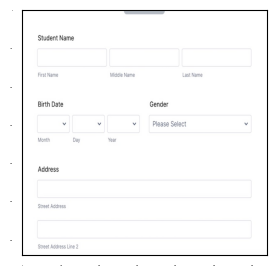

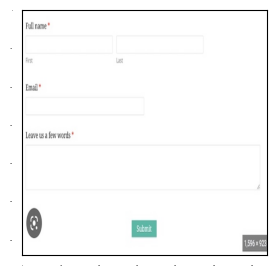

In [6]:
#this block fetches the image data and sorts them in order in line with other scripts and converted to numpy

#image data file path
data_dir = "..//data"
#get all the jpeg file names 
file_names_images = []
os.chdir(data_dir)
for file in glob.glob("*.jpg"):
    file_names_images.append(file)

#sort these in order. note that the naming of file is it should start from '100,101,...'. 
#this format is validated in 'retinanet_labelImg'
file_names_sorted = []
for file in file_names_images:
    file_names_sorted.append(int(file[0:3]))

file_names_sorted.sort()
file_names = [str(x)+'.jpg' for x in file_names_sorted]

train_images_np = viz_data(file_names)


In [7]:
#fetch ground truth boxes and indices class list in .npy format 
#these 2 files are generated from another script called bbox

gt_boxes = np.load('../data/bbox.npy', allow_pickle=True)
indices_class_list = np.load('../data/indices_class_list.npy', allow_pickle=True)

In [8]:
#define category index
num_classes = 3
input_field_id = 1
dropdown_id = 2
text_id = 3

category_index = {
    input_field_id: {'id': input_field_id, 'name': 'Input Field'},
    dropdown_id:{'id':dropdown_id, 'name':'Drop Down'},
    text_id:{'id':text_id, 'name':'Text'}
    }

In [9]:
# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index. This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np,indices_class) in zip(
    train_images_np, gt_boxes,indices_class_list):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = indices_class-1
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))

print('Done prepping data.')


Done prepping data.


<class 'numpy.ndarray'>
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


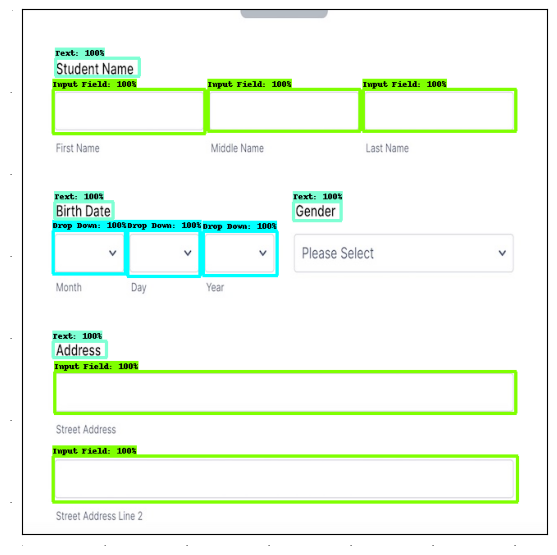

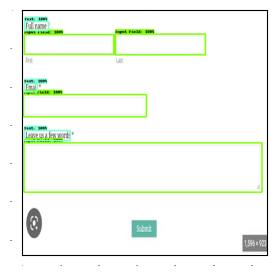

In [10]:
#for multiple object detection
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%
print(type(train_images_np[0]))
plt.figure(figsize=(30, 15))
for idx in range(2):
  plt.subplot(2, 3, idx+1)
  dummy_scores = tf.convert_to_tensor(np.ones((1, gt_boxes[idx].shape[0]),dtype=np.float32))

  plot_detections_tensor(
      tf.convert_to_tensor(np.expand_dims(train_images_np[idx], axis=0)),
      tf.convert_to_tensor(np.expand_dims(gt_boxes[idx], axis=0)),
      tf.convert_to_tensor(np.expand_dims(indices_class_list[idx], axis=0)),
      dummy_scores, category_index)
plt.show()

In [11]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
#num_classes = 2
num_classes = 3
pipeline_config = '../../../Development/IntelLearnSys/models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = '../../../Development/IntelLearnSys/models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    #_prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...


2023-04-10 13:05:43.455647: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8388608 exceeds 10% of free system memory.
2023-04-10 13:05:43.569165: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8388608 exceeds 10% of free system memory.
2023-04-10 13:05:43.575721: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8388608 exceeds 10% of free system memory.
2023-04-10 13:05:43.817931: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9437184 exceeds 10% of free system memory.
2023-04-10 13:05:43.942994: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9437184 exceeds 10% of free system memory.


Weights restored!


In [12]:
#EAGER mode training loop

tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01 #orginally 0.01
num_batches = 100
#num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
 
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

/home/cmathan/.local/lib/python3.10/site-packages/keras/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Start fine-tuning!
batch 0 of 100, loss=1.363327
batch 10 of 100, loss=0.41618422
batch 20 of 100, loss=0.16855694
batch 30 of 100, loss=0.09095386
batch 40 of 100, loss=0.06097819
batch 50 of 100, loss=0.046726745
batch 60 of 100, loss=0.04003659
batch 70 of 100, loss=0.035683412
batch 80 of 100, loss=0.032680474
batch 90 of 100, loss=0.03026006
Done fine-tuning!


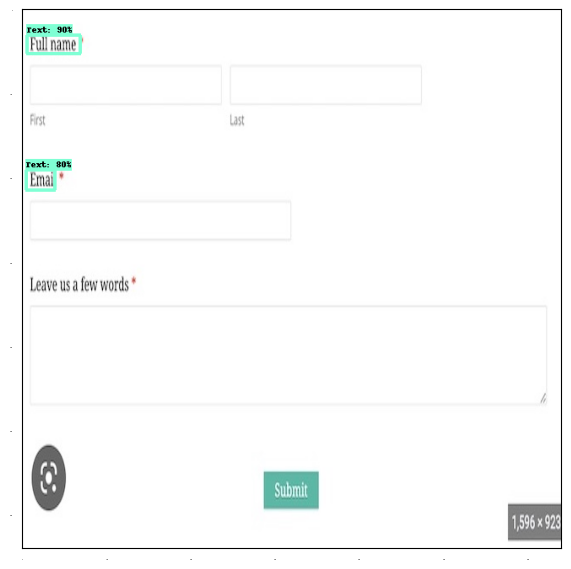

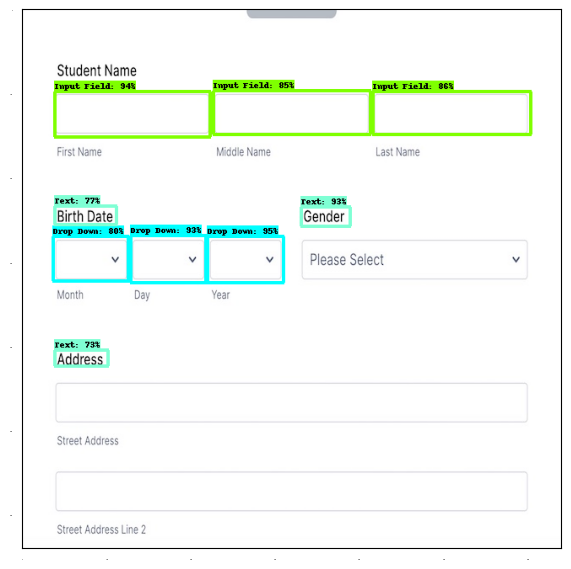

In [13]:

#image data file path
data_dir = "..//data"
#get all the jpeg file names 
file_names_images = []
os.chdir(data_dir)
for file in glob.glob("*.jpg"):
    file_names_images.append(file)



test_images_np = []
for file_name in file_names_images:
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(file_name), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
#@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)
  plot_detections_tensor(
      tf.convert_to_tensor(test_images_np[i]),
      detections['detection_boxes'],
      tf.dtypes.cast(detections['detection_classes']+label_id_offset, tf.int8),
      detections['detection_scores'],
      category_index)
  plt.show()

In [2]:
import platform
print(platform.python_version())

3.8.0
